# Introduction to atomman: Volterra dislocation models

__Lucas M. Hale__, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), _Materials Science and Engineering Division, NIST_.
    
[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm) 

## 1. Introduction

This Notebook provides an introduction to the tools in atomman for computing elasticity solutions for straight Volterra dislocations.

- atomman.defect.solve_volterra_dislocation() is a wrapper function that returns one of the two classes below based on the supplied elastic constants.

- atomman.defect.IsotropicVolterraDislocation class uses the classical analytical equations associated with the isotropic straight dislocation.

- atomman.defect.Stroh class solves the Eshelby anisotropic straight dislocation problem using the Stroh (eigenvector) method.

Both calculation classes are children of the atomman.defect.VolterraDislocation template class, and therefore provide a similar interface for initialization and obtaining evaluated properties. 

__NOTE__: This Notebook outlines the methods in atomman for obtaining elastic solutions for Volterra dislocations.  If you wish to construct atomic configurations of dislocations based on the Volterra solutions, check out the [04.9. Dislocation class Jupyter Notebook](04.9._Dislocation_class.html). 

**Library Imports**

In [1]:
# Standard libraries
import os
import datetime
from copy import deepcopy

# http://www.numpy.org/
import numpy as np     
np.set_printoptions(precision=3)

import matplotlib.pyplot as plt
%matplotlib inline

# https://github.com/usnistgov/atomman
import atomman as am
import atomman.unitconvert as uc

# Show atomman version
print('atomman version =', am.__version__)

# Show date of Notebook execution
print('Notebook executed on', datetime.date.today())

atomman version = 1.3.5
Notebook executed on 2020-10-06


## 2. Theory

Dislocation theory is based on computing and using elasticity solutions of dislocations to define what they look like and how they interact with the surrounding material. The Volterra dislocation model assumes that the discontinuity in the crystal due to the dislocation exists as a line singularity. While this assumption does not hold true in real materials, the Volterra solution is still a good estimate far from the dislocation core. It also provides a useful starting point for developing more complicated dislocation solutions, and can provide a decent initial guess for constructing atomic dislocation configurations.

For straight dislocations, the solutions are always defined relative to three orthogonal unit vectors $m_i$, $n_i$, and $\xi_i$ 

- $m_i$ is the direction in the slip plane perpendicular to the line direction.

- $n_i$ is the normal of the dislocation's slip plane.

- $\xi_i$ is parallel to the dislocation's line direction.

Based on these three vectors, we can define a Cartesian coordinate system for the dislocation solution with positions, $x_i$, 
given by

$$ x_i = x_1 m_i + x_2 n_i + x_3 \xi_i $$ 




### 2.1 Isotropic solution

Analytical equations for the isotropic dislocation solution can be found in nearly every textbook focused on dislocation theory.  The equations used in atomman are close to those found in Elementary Dislocation Theory by Weertman and Weertman, except with flipped signs. 

Isotropic elastic constants can be represented using only two independent terms. For dislocation solutions, the two isotropic elastic constants typically used are the shear modulus, $\mu$, and the Poisson's ratio, $\nu$. 

With a straight dislocation, the solution is independent of the $x_3$ direction and therefore only depends on $x_1$ and $x_2$. 

The specific isotropic equations used here were selected such that values and periods compare well with the Stroh results.

### 2.2 Basics of the Stroh method

Starting with the fundamental equations of elasticity:

$$ \sigma_{ij} = C_{ijkl} \epsilon_{kl} $$

$$ \epsilon_{ij} = \frac{1}{2} \left(\frac{\partial u_i}{\partial x_j} + \frac{\partial u_j}{\partial x_i}\right) $$

$$ \frac{\partial \sigma_{ij}}{\partial x_j} = 0 $$

Combining these and taking the solution to be independent of $x_3$ generates the partial differential equation:

$$ C_{ijkl} \frac{ \partial^2 u_k}{\partial x_j \partial x_l} = 0 $$

Solutions of the partial differential equation are of the form 

$$ u_k = A_k f(x_1 + p x_2) $$

Values of $A_k$ and $p$ can be found by solving

$$ \left[C_{i1k1} + \left(C_{i1k2} + C_{i2k1} \right) p + C_{i2k2} p^2 \right] A_k = 0 $$

The determinate expression is a sixth-order polynomial expression resulting in six complex roots, $p_\alpha$ with $\alpha$ ranging 1 to 6. There is also one $A_{k \alpha}$ corresponding to each root.

With the Stroh method for solving the problem, another vector, $L_i$ is defined for each $\alpha$ root as

$$ L_{i \alpha} = \left(C_{i2k1} + p_{\alpha} C_{i2k2} \right) A_{k \alpha} $$

and a normalization factor, $k_{\alpha}$, as

$$ k_{\alpha} = \frac{1}{2 A_{j \alpha} L_{j \alpha}} $$

Stroh's method is then to write the problem as an eigenvector problem, which solving gives values for $p_{\alpha}$, $A_{i \alpha}$, and $L_{i \alpha}$.  Properties of the dislocation can then be computed with equations that use these solution parameters.

## 3. Get solution

A Volterra dislocation solution can be obtained by either calling the solve_volterra_dislocation() function, or by initializing one of the dislocation solution classes. The two classes also have a solve() method that allows for a new solution to be obtained using the same object. The solve_volterra_dislocation() function, the class initializers, and the class solve methods all accept the same set of parameters.

*Update Version 1.3.2: ξ_uvw, slip_hkl, and box parameters added to make defining systems easier, especially for non-cubic crystals.  axes renamed to transform for clarity.*

Parameters

- **C** (*atomman.ElasticConstants*) The medium's elastic constants.

- **burgers** (*array-like object*) The dislocation's Burgers vector.

- **ξ_uvw** (*array-like object*) The Miller crystal vector associated with the dislocation's line direction.  Must be given with slip_hkl to identify the transformation matrix to use on C and burgers.

- **slip_hkl** (*array-like object*) The Miller plane indices associated with the dislocation's slip plane.  Must be given with slip_hkl to identify the transformation matrix to use on C and burgers.
 
- **transform** (*array-like object, optional*) A 3x3 set of orthogonal Cartesian vectors that define the transformation matrix to use on C and burgers to convert from the standard (unit cell) and dislocation orientations.  The 3 vectors will automatically be converted into unit vectors.  Using this is an alternative to using ξ_uvw and slip_hkl.

- **axes** (*array-like object, optional*) Same as transform.  Retained for backwards compatibility.

- **box** (*atomman.Box, optional*) The unit cell's box that crystal vectors are taken with respect to. If not given, will use a cubic box with a=1 meaning that burgers, ξ_uvw and slip_hkl will be interpreted as Cartesian vectors.

- **m** (*array-like object, optional*) The m Cartesian unit vector for the solution giving the $x_1$ direction.  m, n, and $\xi$ (dislocation line direction) should be right-hand orthogonal.  Default value is [1,0,0] (Cartesian x-axis).

- **n** (*array-like object, optional*) The n Cartesian unit vector for the solution giving the $x_2$ direction.  m, n, and $\xi$ (dislocation line direction) should be right-hand orthogonal.  Default value is [0,1,0] (Cartesian y-axis).

- **tol** (*float*) Tolerance parameter used to round off near-zero values.  Default value is 1e-8.

### 3.1 Specify input parameters

#### 3.1.1 Cu fcc unit cell 

The dislocation solution only needs the box, but the full unit cell is used Section 5 to generate atomic configurations.

In [2]:
a = uc.set_in_units(3.6, 'angstrom')
box = am.Box.cubic(a=a)

atoms = am.Atoms(pos=[[0.0,0.0,0.0], [0.5,0.5,0.0], [0.5,0.0,0.5], [0.0,0.5,0.5]])

ucell = am.System(box=box,
                  atoms=atoms, 
                  scale=True)
print(ucell)

avect =  [ 3.600,  0.000,  0.000]
bvect =  [ 0.000,  3.600,  0.000]
cvect =  [ 0.000,  0.000,  3.600]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
symbols = (None,)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   1.800 |   1.800 |   0.000
      2 |       1 |   1.800 |   0.000 |   1.800
      3 |       1 |   0.000 |   1.800 |   1.800


#### 3.1.2 fcc a/2<10-1>{111} dislocation

In [3]:
burgers = 0.5 * np.array([1, 0, -1])
slip_hkl = np.array([1, 1, 1])

# The dislocation's line direction (ξ_uvw) determines character
ξ_uvw = [ 1,-2, 1] # 90 degree edge
#ξ_uvw = [1, -1, 0] # 60 degree mixed
#ξ_uvw = [1, 1, -2] # 30 degree mixed
#ξ_uvw = [1, 0, -1] # 0 degree screw

#### 3.1.3 Dislocation system orientation

In [4]:
m = [0, 1, 0] # align edge component with the y-axis
n = [0, 0, 1] # align slip plane normal with the z-axis

#### 3.1.4 Elastic constants

In [5]:
# Rough isotropic values for Cu
#E = uc.set_in_units(130, 'GPa')
#Poisson = 0.34
#C = am.ElasticConstants(E=E, nu=Poisson)

# Rough anisotropic values for Cu
C11 = uc.set_in_units(169, 'GPa')
C12 = uc.set_in_units(122, 'GPa')
C44 = uc.set_in_units(75.4, 'GPa')
C = am.ElasticConstants(C11=C11, C12=C12, C44=C44)
print(uc.get_in_units(C.Cij, 'GPa'), 'GPa')

[[169.  122.  122.    0.    0.    0. ]
 [122.  169.  122.    0.    0.    0. ]
 [122.  122.  169.    0.    0.    0. ]
 [  0.    0.    0.   75.4   0.    0. ]
 [  0.    0.    0.    0.   75.4   0. ]
 [  0.    0.    0.    0.    0.   75.4]] GPa


### 3.2 Build solution and check configuration

#### 3.2.1 Build solution

Passing box to the solution allows for burgers, ξ_uvw, and slip_hkl to be given as crystal vectors.
Passing ξ_uvw, and slip_hkl to the solution allows for C and burgers to be defined relative to the standard (unit cell) reference.

In [6]:
solution = am.defect.solve_volterra_dislocation(C, burgers, ξ_uvw=ξ_uvw, slip_hkl=slip_hkl, box=box, m=m, n=n)

#### 3.2.2 Check configuration values

In [7]:
print('Dislocation configuration:')
print('m:        ', solution.m)
print('n:        ', solution.n)
print('ξ:        ', solution.ξ)
print('Burgers:  ', uc.get_in_units(solution.burgers, 'angstrom'), 'angstrom')
print('|Burgers|:', uc.get_in_units(np.linalg.norm(solution.burgers), 'angstrom'), 'angstrom')
print('Character:', solution.characterangle(), 'degrees')
print()
print('Transformation matrix from standard orientation to dislocation orientation:')
print(solution.transform)


Dislocation configuration:
m:         [0. 1. 0.]
n:         [0. 0. 1.]
ξ:         [1. 0. 0.]
Burgers:   [0.    2.546 0.   ] angstrom
|Burgers|: 2.545584412271571 angstrom
Character: 90.0 degrees

Transformation matrix from standard orientation to dislocation orientation:
[[ 0.408 -0.816  0.408]
 [ 0.707  0.    -0.707]
 [ 0.577  0.577  0.577]]


#### 3.2.3 Show underlying solution parameters

In [8]:
if isinstance(solution, am.defect.IsotropicVolterraDislocation):
    print('Solution is isotropic')
    print(f'mu -> {uc.get_in_units(solution.mu, "GPa"):.3f} GPa')
    print(f'nu -> {solution.nu:.3f}')

elif isinstance(solution, am.defect.Stroh):
    print('Solution is anisotropic')
    print('p ->')
    print(solution.p)
    print('A ->')
    print(solution.A)
    print('L ->')
    print(solution.L)
    print('k ->')
    print(solution.k)

Solution is anisotropic
p ->
[-0.574+1.481j -0.574-1.481j  0.574+1.481j  0.574-1.481j  0.   +0.394j
  0.   -0.394j]
A ->
[[ 6.672e-01+0.000e+00j -4.925e-01+2.927e-01j -1.867e-01-9.776e-02j]
 [ 6.672e-01-0.000e+00j -4.925e-01-2.927e-01j -1.867e-01+9.776e-02j]
 [ 6.672e-01+0.000e+00j  4.925e-01+2.927e-01j -1.867e-01+9.776e-02j]
 [ 6.672e-01-0.000e+00j  4.925e-01-2.927e-01j -1.867e-01-9.776e-02j]
 [-4.278e-01-3.101e-16j  2.497e-17+1.473e-01j -7.891e-01+0.000e+00j]
 [-4.278e-01+3.101e-16j  2.497e-17-1.473e-01j -7.891e-01-0.000e+00j]]
L ->
[[ 2.238e-02-2.069e-01j  1.878e-01+2.534e-01j -1.060e-01+1.679e-01j]
 [ 2.238e-02+2.069e-01j  1.878e-01-2.534e-01j -1.060e-01-1.679e-01j]
 [-2.238e-02-2.069e-01j  1.878e-01-2.534e-01j  1.060e-01+1.679e-01j]
 [-2.238e-02+2.069e-01j  1.878e-01+2.534e-01j  1.060e-01-1.679e-01j]
 [-4.443e-17+6.540e-02j  1.504e-01+5.955e-17j  1.110e-16+3.818e-01j]
 [-4.443e-17-6.540e-02j  1.504e-01-5.955e-17j  1.110e-16-3.818e-01j]]
k ->
[-8.788e-01+1.741j -8.788e-01-1.741j  8

## 4. Derived properties

Different properties of the solution can be derived from the solution parameters and obtained as other attributes of the class.

### 4.1 Energy coefficient tensor, K_tensor

The energy coefficient tensor is a property of the solution that is useful for dislocation stress and energy calculations. It only depends on the elastic constants and the orientation.

**Caution**: $K_{ij}$ is defined differently by different authors and may vary by multiplicative factors. Here, it is taken such that the isotropic screw component is the shear modulus, $\mu$.

#### 4.1.1 Isotropic

In the isotropic case, the only non-zero components (in the dislocation orientation) are

$$K_{11}^{iso} = K_{22}^{iso} = K_{edge}^{iso} = \frac{\mu}{1 - \nu}$$
$$K_{33}^{iso} = K_{screw}^{iso} = \mu$$

#### 4.1.2 Anisotropic

The tensor can be obtained from the Stroh solution parameters as

$$ K_{jl} = i \sum_{\alpha} \pm k_{\alpha} L_{j \alpha} L_{l \alpha} $$

where $i$ is the imaginary unit and the $\pm$ sense alternates for even/odd values of $\alpha$ (the six partial solutions are three pairs of complex conjugates).


In [9]:
print('K_tensor (in GPa) ->')
print(uc.get_in_units(solution.K_tensor, 'GPa'))

K_tensor (in GPa) ->
[[44.217  0.    -8.628]
 [ 0.    74.096  0.   ]
 [-8.628  0.    74.933]]


### 4.2 Energy coefficient, K_coeff

The energy coefficient, $K$, is a dislocation-specific coefficient found in expressions for a dislocation's self-energy

$$\frac{W}{l} = \frac{K b^2}{4 \pi} \ln{ \left( \frac{R}{r_0} \right)}, $$

where $b$ is the magnitude of $b_i$, and $r_0$ and $R$ are the inner and outer radii of a cylindircal ring around the dislocation. The energy coefficient can be computed from the energy coefficent tensor and burgers vector

$$ K = \frac{b_i K_{ij} b_j} {b_k b_k} $$



In [10]:
# Note values are same as K11 component above due to pure edge dislocation
print(f'K_coeff -> {uc.get_in_units(solution.K_coeff, "GPa"):.3f} GPa')

K_coeff -> 74.096 GPa


### 4.3 Pre-logarithmic factor, preln

Alternatively, the self-energy expression can be represented as

$$\frac{W}{l} = a \ln{ \left( \frac{R}{r_0} \right)}, $$

where $a$ is referred to as the pre-logarithmic energy factor and is in units of energy/length. Related to $K$ and $K_{ij}$,

$$ a = \frac{b_i K_{ij} b_j}{4 \pi} = \frac{K b^2}{4 \pi} $$

In [11]:
print(f'preln -> {uc.get_in_units(solution.preln, "eV/Å"):f} eV/Å')

preln -> 0.238480 eV/Å


### 4.4 displacements

Position-based displacements associated with the elastic solution can be calculated using either model.  Note that the solution assumes the dislocation's position to be at coorinates (0, 0) for 

#### 4.4.1 Isotropic equations

$$ u_1 = \frac{b_1}{2 \pi} \left[ \theta + \frac{x_1x_2}{2 (1 - \nu) (x_1^2 + x_2^2)} \right]$$

$$ u_2 = \frac{b_1}{2 \pi} \left[ -\frac{1 - 2 \nu} {4 (1 - \nu)} \ln(x_1^2 + x_2^2)
                           + \frac{y^2} {2 (1 - \nu) (x^2 + y^2)} \right]$$

$$ u_3 = \frac{b_3}{2 \pi} \theta.$$

Here (and below), $\theta$ is the radial angle coordinate

$$\theta=\tan^{-1} (x_2/x_1),$$

which is taken to range from $-\pi$ to $\pi$.

#### 4.4.2 Anisotropic equations

$$ u_j = \frac{1}{2 \pi i} \sum_{\alpha}  \pm k_{\alpha} A_{j \alpha} (L_{l \alpha} b_l) \ln{\eta_{\alpha}}.$$

Here (and below), $\eta$ is an imaginary coordinate  that combines $x_1$ and $x_2$ using the computed eigenvalues $p_{\alpha}$

$$ \eta_{\alpha} = x_1 + p_{\alpha} x_2 $$

In [12]:
# Generate spacial grid of points
xy_max = 15
num_xy = 100
xvals = yvals = np.linspace(-xy_max, xy_max, num_xy)
xvals, yvals = np.meshgrid(np.linspace(-xy_max, xy_max, 100), np.linspace(-xy_max, xy_max, num_xy))

# Convert points to coordinates relative to dislocation system
coords = np.outer(xvals, m) + np.outer(yvals, n)

# Identify x, y directions
if np.isclose(m[0], 1.0):
    xlabel = '$x_1$'
elif np.isclose(m[1], 1.0):
    xlabel = '$x_2$'
elif np.isclose(m[2], 1.0):
    xlabel = '$x_3$'
if np.isclose(n[0], 1.0):
    ylabel = '$x_1$'
elif np.isclose(n[1], 1.0):
    ylabel = '$x_2$'
elif np.isclose(n[2], 1.0):
    ylabel = '$x_3$'

Coordinates and displacements in Angstroms


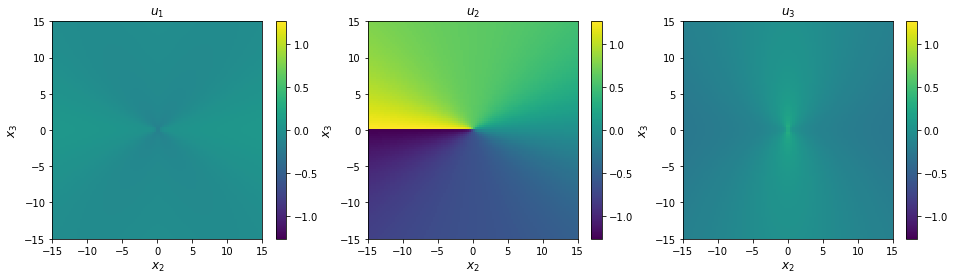

In [13]:
# Compute displacements
disp = solution.displacement(coords)

# Plot
disp_max = np.abs(disp.max())
fig, axes = plt.subplots(figsize=(16,4), ncols=3)

for i in range(3):
    im = axes[i].pcolormesh(xvals, yvals, disp[:,i].reshape(num_xy, num_xy), vmin=-disp_max, vmax=disp_max)
    axes[i].set_title(f'$u_{{{i+1}}}$')
    axes[i].set_xlabel(xlabel, fontsize='large')
    axes[i].set_ylabel(ylabel, fontsize='large')
    fig.colorbar(im, ax=axes[i])

print('Coordinates and displacements in Angstroms')
plt.show()

### 4.5 stress

The stress state associated with the elastic solution can also be calculated at a given position for both models

#### 4.5.1 Isotropic equations

$$ \sigma_{11} = -\frac{\mu b_1}{2 \pi (1 - \nu)} \frac{x_2 (3 x_1^2 + x_2^2)} { (x_1^2 + x_2^2)^2}$$

$$ \sigma_{22} = \frac{\mu b_1}{2 \pi (1 - \nu)} \frac{x_2 (x_1^2 - x_2^2)} { (x_1^2 + x_2^2)^2}$$

$$ \sigma_{33} = \nu(\sigma_{11} + \sigma_{22})$$

$$ \sigma_{12} = \frac{\mu b_1}{2 \pi (1 - \nu)} \frac{x_1(x_1^2 - x_2^2)) }{ (x_1^2 + x_2^2)^2}$$

$$ \sigma_{13} =-\frac{\mu b_3}{2 \pi} \frac{x_2}{(x_1^2 + x_2^2)} $$

$$ \sigma_{23} = \frac{\mu b_3}{2 \pi} \frac{x_1}{(x_1^2 + x_2^2)} $$

#### 4.5.2 Anisotropic equations

$$ \sigma_{ij} = \frac{1}{2 \pi i} \sum_{\alpha}  \pm k_{\alpha} C_{ijkl}[m_l + p_{\alpha} n_l] A_{k \alpha} (L_{m \alpha} b_m) \frac{1}{\eta_{\alpha}} $$

Stress components in GPa, coordinates in Angstroms


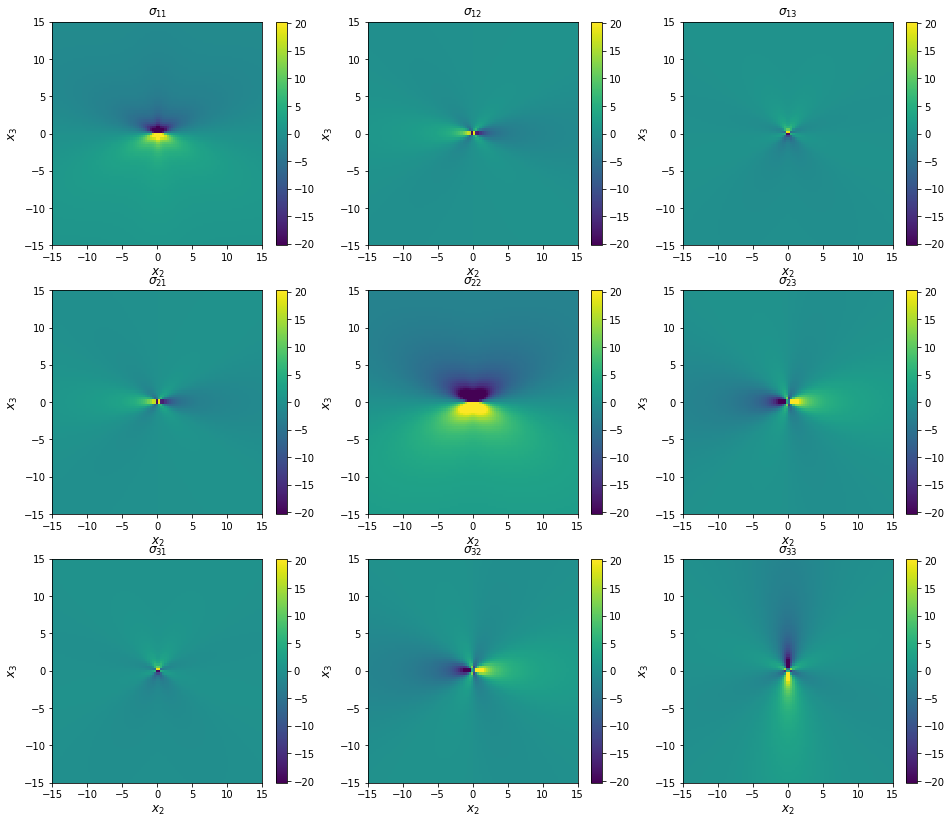

In [14]:
# Compute stress states
stress = uc.get_in_units(solution.stress(coords), 'GPa')

# Plot
stress_max = np.abs(stress.max()) / 10
fig, axes = plt.subplots(figsize=(16,14), ncols=3, nrows=3)

for i in range(3):
    for j in range(3):
        im = axes[i, j].pcolormesh(xvals, yvals, stress[:, i, j].reshape(num_xy, num_xy), vmin=-stress_max, vmax=stress_max)
        axes[i, j].set_title(f'$\sigma_{{{i+1}{j+1}}}$')
        axes[i, j].set_xlabel(xlabel, fontsize='large')
        axes[i, j].set_ylabel(ylabel, fontsize='large')
        fig.colorbar(im, ax=axes[i, j])

print('Stress components in GPa, coordinates in Angstroms')
plt.show()

## 5. Generate dislocation configurations

*Added version 1.3.4*: The Dislocation class provides a user-friendly interface for generating dislocation monopole and periodic array of dislocation atomic configurations using Volterra solutions.  See the [04.9. Dislocation class Jupyter Notebook](04.9._Dislocation_class.html) for more details.

### 5.1. Start with a unit cell

In [15]:
# Unit cell as defined above
print(ucell)

avect =  [ 3.600,  0.000,  0.000]
bvect =  [ 0.000,  3.600,  0.000]
cvect =  [ 0.000,  0.000,  3.600]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
symbols = (None,)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   1.800 |   1.800 |   0.000
      2 |       1 |   1.800 |   0.000 |   1.800
      3 |       1 |   0.000 |   1.800 |   1.800


### 5.2 Use dislocation_system_basis to identify the rotation crystal vectors

For cubic systems, the a_uvw, b_uvw, c_uvw crystal vectors to rotate the system by can be easily worked out from the defined system orientation parameters and the transformation matrix.  For non-cubic systems, it is a trickier problem and the dislocation_system_basis function was created to assist with this by searching for crystal vectors close to the transformation matrix vectors.

**NOTE:** This function will throw an error if the identified uvws are not compatible with how LAMMPS defines the system boxes. For the general non-cubic case, always use m=[0,1,0] and n=[0,0,1]! See Section 6 below for more details.   

Parameters

- **ξ_uvw** (*array-like object*) The Miller crystal vector associated with the dislocation's line direction.

- **slip_hkl** (*array-like object*) The Miller plane indices associated with the dislocation's slip plane.

- **m** (*array-like object, optional*) The m Cartesian unit vector for the solution giving the $x_1$ direction.  m, n, and $\xi$ (dislocation line direction) should be right-hand orthogonal.  Default value is [1,0,0] (Cartesian x-axis).

- **n** (*array-like object, optional*) The n Cartesian unit vector for the solution giving the $x_2$ direction.  m, n, and $\xi$ (dislocation line direction) should be right-hand orthogonal.  Default value is [0,1,0] (Cartesian y-axis).

- **box** (*atomman.Box, optional*) The unit cell's box that crystal vectors are taken with respect to. If not given, will use a cubic box with a=1 meaning that ξ_uvw and slip_hkl will be interpreted as Cartesian vectors

- **tol** (*float, optional*) Tolerance parameter used to round off near-zero values.  Default value is 1e-8.

- **maxindex** (*int, optional*) The maximum Miller index to use when searching for crystal vectors.  Default value is 10.

- **return_hexagonal** (*bool, optional*) Indicates if the indices are to be returned as 4-coordinate Miller-Bravais indices.  Default value is False.

- **return_transform** (*bool, optional*) If True, the transformation matrix will also be returned. Default value is False.

Returns

- **uvws** (*array-like object*) The rotation crystal vector to use.

- **transform** (*array-like object*) The transformation matrix corresponding to the rotation. Returned if return_transform is True.


In [16]:
uvws = am.defect.dislocation_system_basis(ξ_uvw, slip_hkl, m=m, n=n, box=box)
print(uvws)

[[ 1. -2.  1.]
 [ 1.  0. -1.]
 [ 1.  1.  1.]]


### 5.3 Rotate ucell using uvws

In [17]:
system = ucell.rotate(uvws)
print(system)

avect =  [ 8.818,  0.000,  0.000]
bvect =  [ 0.000,  5.091,  0.000]
cvect =  [ 0.000,  0.000,  6.235]
origin = [ 0.000,  0.000,  0.000]
natoms = 24
natypes = 1
symbols = (None,)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   2.205 |   3.818 |   6.235
      1 |       1 |   8.818 |   2.546 |   0.000
      2 |       1 |   6.614 |   3.818 |   6.235
      3 |       1 |   6.614 |   1.273 |   6.235
      4 |       1 |   8.083 |   3.818 |   2.078
      5 |       1 |   2.205 |   1.273 |   6.235
      6 |       1 |   4.409 |   0.000 |   6.235
      7 |       1 |   4.409 |   2.546 |   6.235
      8 |       1 |   3.674 |   3.818 |   2.078
      9 |       1 |   5.879 |   2.546 |   2.078
     10 |       1 |   3.674 |   1.273 |   2.078
     11 |       1 |   5.144 |   3.818 |   4.157
     12 |       1 |   0.000 |   0.000 |   0.000
     13 |       1 |   1.470 |   0.000 |   2.078
     14 |       1 |   1.470 |   2.546

### 5.4 Shift atoms off of the slip plane

In [18]:
# Identify the unique coorinates normal to the slip plane
y_coords = system.atoms.pos.dot(n)
unique = []
for y in y_coords:
    if np.sum(np.isclose(np.array(unique), y)) == 0:
        unique.append(y)
unique = np.unique(unique)
print(unique)

[2.756e-16 2.078e+00 4.157e+00 6.235e+00]


In [19]:
# Shift positions by half the atomic spacing (plus a tiny bit along m)
system.atoms.pos += np.array(n) * (unique[1] - unique[0]) / 2 + np.array(m) * 0.05
system.wrap()

Supersize

In [20]:
ξ = np.cross(m, n)
if np.isclose(ξ[0], 1.0):
    system = system.supersize(1, (-3, 3), (-3, 3))
elif np.isclose(ξ[1], 1.0):
    system = system.supersize((-3, 3), 1, (-3, 3))
elif np.isclose(ξ[2], 1.0):
    system = system.supersize((-3, 3), (-3, 3), 1)

Plot xy cross section of atoms

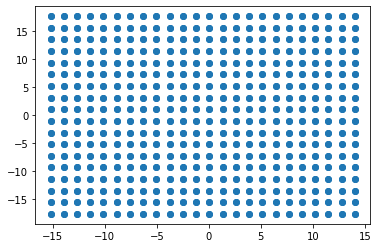

In [21]:
# plot original positions of atoms in system
plt.plot(system.atoms.pos.dot(m), system.atoms.pos.dot(n), 'o')
plt.show()

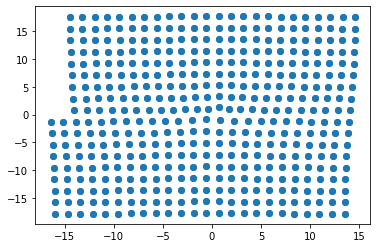

In [22]:
# Compute displacements for all positions
disp = solution.displacement(system.atoms.pos)

# Apply displacements to positions
system.atoms.pos += disp

# plot new positions of atoms in system
plt.plot(system.atoms.pos.dot(m), system.atoms.pos.dot(n), 'o')
plt.show()

## 6. General case considerations

Properly building atomistic systems with dislocations using the Stroh method requires careful considerations regarding the system orientation.  This is complicated by the need to think in terms of multiple axes systems

- $[hkl]$ crystal vectors are commonly used to define dislocation types and slip planes.  These vectors are taken relative to the box vectors of a unit cell in a standard reference frame.

- The atomistic system's orientation is defined by specifying $[hkl]$ crystal vectors to coincide with the system's $a_i$, $b_i$, $c_i$ box vectors.

- The atomic positions within the atomistic system are represented with Cartesian $x'_i$ coordinates.

- The elastic solution is defined for Cartesian $x_i$ coordinates, where $x_2$ is normal to the slip plane and $x_3$ is parallel to the dislocation line.

As the latter two are both Cartesian, $x_i$ values are easily obtained from $x'_i$ using transformation unit vectors $m_i$ and $n_i$

- $x_1 = m_i x'_i$

- $x_2 = n_i x'_i$

- $x_3$ values not needed as the elastic solution is invariant in that direction.

Depending on the crystal structure and dislocation type, it is not always possible to construct a system with orthogonal box vectors.  This means that the $a_i$, $b_i$, $c_i$ box vectors will not necessarily align with the $x'_i$ axes.  For this general case, the following requirements and choices can help with orientation decisions

- The dislocation's line direction must be parallel to one of the box vectors for the dislocation to remain infinitely straight.

- For convenience, each of the elastic solution's $x_i$-axes should map to one of the atomic system's $x'_i$-axes.  This is accomplished if both the dislocation line and the slip plane normal are oriented along $x'_i$-axes.

With LAMMPS-compatible system boxes

- The $a_i$ box vector is always aligned with the $x'_1$-axis, therefore the dislocation line should be parallel to the $a_i$ vector / $x'_1$-axis.

- The $a_i$ and $b_i$ box vectors have no component in the $x'_3$ direction, i.e. the plane containing both $a_i$ and $b_i$ is normal to the $x'_3$-axis.  The slip plane normal can then be taken as parallel to the $x'_3$-axis.

- Related to the elastic solution, this makes $x_1$ parallel to the $x'_2$-axis, $x_2$ parallel to the $x'_3$-axis, and $x_3$ parallel to the $x'_1$-axis. The corresponding $m_i$ and $n_i$ values are

    - $m_i = [0, 1, 0]$
    
    - $n_i = [0, 0, 1]$

### 6.1 Dislocation solution for arbitrary crystal

The dislocation solution itself does not have any limitations for arbitrary crystal families as long as 

In [23]:
# Arbitary triclinic box (just for testing)
box = am.Box(a=3.6, b=3.4, c=6.9, alpha=89, beta=76, gamma=110)

# Keep "face-centered" coordinates because why not
atoms = am.Atoms(pos=[[0.0,0.0,0.0], [0.5,0.5,0.0], [0.5,0.0,0.5], [0.0,0.5,0.5]])

ucell = am.System(box=box,
                  atoms=atoms, 
                  scale=True)
print(ucell)

avect =  [ 3.600,  0.000,  0.000]
bvect =  [-1.163,  3.195,  0.000]
cvect =  [ 1.669,  0.736,  6.654]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
symbols = (None,)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   1.219 |   1.597 |   0.000
      2 |       1 |   2.635 |   0.368 |   3.327
      3 |       1 |   0.253 |   1.965 |   3.327


In [24]:
# Arbitary elastic constants (just for testing)
cdict={}
cdict['C11'] = uc.set_in_units(169, 'GPa')
cdict['C12'] = uc.set_in_units(122, 'GPa')
cdict['C13'] = uc.set_in_units(121, 'GPa')
cdict['C14'] = uc.set_in_units(101, 'GPa')
cdict['C15'] = uc.set_in_units(3, 'GPa')
cdict['C16'] = uc.set_in_units(1, 'GPa')
cdict['C22'] = uc.set_in_units(160, 'GPa')
cdict['C23'] = uc.set_in_units(125, 'GPa')
cdict['C24'] = uc.set_in_units(98, 'GPa')
cdict['C25'] = uc.set_in_units(-2, 'GPa')
cdict['C26'] = uc.set_in_units(4, 'GPa')
cdict['C33'] = uc.set_in_units(170, 'GPa')
cdict['C34'] = uc.set_in_units(109, 'GPa')
cdict['C35'] = uc.set_in_units(2, 'GPa')
cdict['C36'] = uc.set_in_units(5, 'GPa')
cdict['C44'] = uc.set_in_units(75, 'GPa')
cdict['C45'] = uc.set_in_units(10, 'GPa')
cdict['C46'] = uc.set_in_units(12, 'GPa')
cdict['C55'] = uc.set_in_units(89, 'GPa')
cdict['C56'] = uc.set_in_units(11, 'GPa')
cdict['C66'] = uc.set_in_units(67, 'GPa')
C = am.ElasticConstants(**cdict)
print(uc.get_in_units(C.Cij, 'GPa'), 'GPa')

[[169. 122. 121. 101.   3.   1.]
 [122. 160. 125.  98.  -2.   4.]
 [121. 125. 170. 109.   2.   5.]
 [101.  98. 109.  75.  10.  12.]
 [  3.  -2.   2.  10.  89.  11.]
 [  1.   4.   5.  12.  11.  67.]] GPa


In [25]:
# Keep crystal definitions the same (everything else is junk anyways)
burgers = 0.5 * np.array([1, 0, -1])
slip_hkl = np.array([1, 1, 1])

# The dislocation's line direction (ξ_uvw) determines character
ξ_uvw = [ 1,-2, 1] 

In [26]:
m = np.array([0, 1, 0])
n = np.array([0, 0, 1])

In [27]:
# Compute solution and show configuration (to prove it still works)
solution = am.defect.solve_volterra_dislocation(C, burgers, ξ_uvw=ξ_uvw, slip_hkl=slip_hkl, box=box, m=m, n=n)

print('Dislocation configuration:')
print('m:        ', solution.m)
print('n:        ', solution.n)
print('ξ:        ', solution.ξ)
print('Burgers:  ', uc.get_in_units(solution.burgers, 'angstrom'), 'angstrom')
print('|Burgers|:', uc.get_in_units(np.linalg.norm(solution.burgers), 'angstrom'), 'angstrom')
print('Character:', solution.characterangle(), 'degrees')
print()
print('Transformation matrix from standard orientation to dislocation orientation:')
print(solution.transform)


Dislocation configuration:
m:         [0. 1. 0.]
n:         [0. 0. 1.]
ξ:         [1. 0. 0.]
Burgers:   [-1.1    3.306  0.   ] angstrom
|Burgers|: 3.4839388709694843 angstrom
Character: 108.40344143799813 degrees

Transformation matrix from standard orientation to dislocation orientation:
[[ 0.656 -0.489  0.575]
 [ 0.51  -0.274 -0.815]
 [ 0.556  0.828  0.07 ]]


In [28]:
uvws = am.defect.dislocation_system_basis(ξ_uvw, slip_hkl, m=m, n=n, box=box, maxindex=5)
print(uvws)

[[ 1. -2.  1.]
 [ 3. -1. -2.]
 [ 1.  1.  0.]]


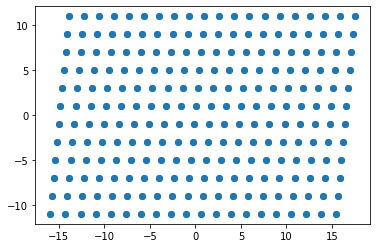

In [29]:
system = ucell.rotate(uvws)
system.atoms.pos += np.array(n) * (2.0) / 2 + np.array(m) * 0.05
system.wrap()
system = system.supersize(1, (-1, 1), (-3, 3))
plt.plot(system.atoms.pos.dot(m), system.atoms.pos.dot(n), 'o')
plt.show()

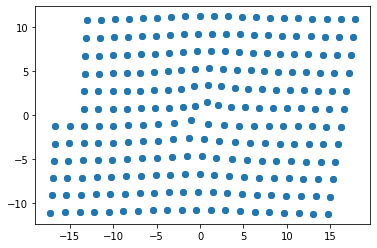

In [30]:
# Compute displacements for all positions
disp = solution.displacement(system.atoms.pos)

# Apply displacements to positions
system.atoms.pos += disp

# plot new positions of atoms in system
plt.plot(system.atoms.pos.dot(m), system.atoms.pos.dot(n), 'o')
plt.show()